## FNN

In [ ]:
import os
import numpy as np
import mne
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy
from datetime import timedelta
from google.colab import drive

drive.mount('/content/drive')

SAMPLING_RATE = 512
DOWNSAMPLED_RATE = 128
WINDOW_SIZE_SEC = 5
WINDOW_SIZE = WINDOW_SIZE_SEC * DOWNSAMPLED_RATE
CHANNELS = 34

dataset_path = '/content/drive/My Drive/Colab Notebooks/IEEE EMBS Internship/EEG Dataset'

seizure_log = {
    "PN00-1.edf": ["19:39:33", ["19:58:36"]],
    "PN00-2.edf": ["02:18:17", ["02:38:37"]],
    "PN00-3.edf": ["18:15:44", ["18:28:29"]],
    "PN00-4.edf": ["20:51:43", ["21:08:29"]]
}

def time_to_seconds(t_str):
    h, m, s = map(int, t_str.split(':'))
    return h * 3600 + m * 60 + s

def seconds_to_clock(seconds):
    return str(timedelta(seconds=int(seconds)))

def extract_features(segment):
    features = []
    for ch_data in segment:
        mean = np.mean(ch_data)
        std = np.std(ch_data)
        var = np.var(ch_data)
        max_val = np.max(ch_data)
        min_val = np.min(ch_data)
        ptp_val = np.ptp(ch_data)
        ent = entropy(np.abs(np.fft.rfft(ch_data)) + 1e-8)
        features.extend([mean, std, var, max_val, min_val, ptp_val, ent])
    return np.array(features)

def preprocess_and_segment(file_path):
    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
    raw.pick_channels(raw.ch_names[:CHANNELS])
    raw.resample(DOWNSAMPLED_RATE)
    data = raw.get_data()

    X, y = [], []
    total_samples = data.shape[1]
    n_windows = total_samples // WINDOW_SIZE

    for i in range(n_windows):
        start = i * WINDOW_SIZE
        end = start + WINDOW_SIZE
        segment = data[:, start:end]
        if segment.shape[1] < WINDOW_SIZE:
            continue
        features = extract_features(segment)
        X.append(features)
    return np.array(X), raw

edf_files = sorted([f for f in os.listdir(dataset_path) if f.endswith('.edf')])
train_files = edf_files[:4]
test_file = edf_files[4]

X_raw, y_raw = [], []
for f in train_files:
    file_path = os.path.join(dataset_path, f)
    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
    raw.pick_channels(raw.ch_names[:CHANNELS])
    raw.resample(DOWNSAMPLED_RATE)
    data = raw.get_data()
    seizure_onsets = [time_to_seconds(t) - time_to_seconds(seizure_log[f][0]) for t in seizure_log[f][1]]

    total_samples = data.shape[1]
    n_windows = total_samples // WINDOW_SIZE

    for i in range(n_windows):
        start = i * WINDOW_SIZE
        end = start + WINDOW_SIZE
        segment = data[:, start:end]
        if segment.shape[1] < WINDOW_SIZE:
            continue
        time_sec = start / DOWNSAMPLED_RATE
        label = int(any((onset - 300) <= time_sec <= onset for onset in seizure_onsets))
        features = extract_features(segment)
        X_raw.append(features)
        y_raw.append(label)

X_raw = np.array(X_raw)
y_raw = np.array(y_raw)

X_train, X_val, y_train, y_val = train_test_split(
    X_raw, y_raw, test_size=0.1, random_state=42, stratify=y_raw
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_data=(X_val, y_val),
    class_weight=class_weights
)

test_path = os.path.join(dataset_path, test_file)
X_test, raw_test = preprocess_and_segment(test_path)
X_test_scaled = scaler.transform(X_test)
preds = model.predict(X_test_scaled)
preds_bin = (preds > 0.5).astype(int).flatten()

segments = []
for i, pred in enumerate(preds_bin):
    if pred == 1:
        start = i * WINDOW_SIZE_SEC
        end = start + WINDOW_SIZE_SEC
        segments.append((start, end))

merged_segments = []
if segments:
    current_start, current_end = segments[0]
    for s, e in segments[1:]:
        if s - current_end == 0 or s - current_end == 5:
            current_end = e
        else:
            merged_segments.append((current_start, current_end))
            current_start, current_end = s, e
    merged_segments.append((current_start, current_end))

print(f"\n🔍 Detected Ictal Segments in {test_file}:")
if merged_segments:
    for start, end in merged_segments:
        print(f"⚠️ Seizure detected between {seconds_to_clock(start)} and {seconds_to_clock(end)}")
else:
    print("✅ No seizure detected.")

np.save('/content/drive/My Drive/Colab Notebooks/IEEE EMBS Internship/fnn_preds.npy', preds)  # for FNN


Mounted at /content/drive


/tmp/ipython-input-2-1141796358.py:81: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-2-1141796358.py:81: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-2-1141796358.py:81: RuntimeWarning: Highpass cutoff frequency 15.91549 is greater than lowpass cutoff frequency 15.0, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-2-1141796358.py:81: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-2-1141796358.py:81: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-2-1141796358.py:81: RuntimeWarning: Highpass cutoff frequency 15.91549 is greater than lowpass cutoff frequency 15.0, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-2-1141796358.py:81: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-2-1141796358.py:81: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-2-1141796358.py:81: RuntimeWarning: Highpass cutoff frequency 15.91549 is greater than lowpass cutoff frequency 15.0, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-2-1141796358.py:81: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-2-1141796358.py:81: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-2-1141796358.py:81: RuntimeWarning: Highpass cutoff frequency 15.91549 is greater than lowpass cutoff frequency 15.0, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Epoch 1/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6902 - loss: 0.6605 - val_accuracy: 0.8325 - val_loss: 0.4471
Epoch 2/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7664 - loss: 0.5048 - val_accuracy: 0.9215 - val_loss: 0.2729
Epoch 3/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8637 - loss: 0.3268 - val_accuracy: 0.8377 - val_loss: 0.4429
Epoch 4/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8283 - loss: 0.3310 - val_accuracy: 0.8953 - val_loss: 0.2340
Epoch 5/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8726 - loss: 0.3046 - val_accuracy: 0.9424 - val_loss: 0.2212
Epoch 6/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8868 - loss: 0.2310 - val_accuracy: 0.9476 - val_loss: 0.1895
Epoch 7/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9208 - loss: 0.1870 - val_accuracy: 0.9319 - val_loss: 0.1990
Epoch 8/30
108/108 ━━━━━

/tmp/ipython-input-2-1141796358.py:55: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-2-1141796358.py:55: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-2-1141796358.py:55: RuntimeWarning: Highpass cutoff frequency 15.91549 is greater than lowpass cutoff frequency 15.0, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

🔍 Detected Ictal Segments in PN00-5.edf:
⚠️ Seizure detected between 0:02:20 and 0:02:30
⚠️ Seizure detected between 0:16:25 and 0:16:35
⚠️ Seizure detected between 0:16:45 and 0:16:50


## Transformer

In [ ]:
# ------------------ STEP 1: Setup ------------------
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy
from datetime import timedelta
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D
import tensorflow as tf
from google.colab import drive

drive.mount('/content/drive')

SAMPLING_RATE = 512
DOWNSAMPLED_RATE = 128
WINDOW_SIZE_SEC = 5
WINDOW_SIZE = WINDOW_SIZE_SEC * DOWNSAMPLED_RATE
CHANNELS = 34
FEATURES_PER_CHANNEL = 7
INPUT_DIM = FEATURES_PER_CHANNEL * CHANNELS

dataset_path = '/content/drive/My Drive/Colab Notebooks/IEEE EMBS Internship/EEG Dataset'

seizure_log = {
    "PN00-1.edf": ["19:39:33", ["19:58:36"]],
    "PN00-2.edf": ["02:18:17", ["02:38:37"]],
    "PN00-3.edf": ["18:15:44", ["18:28:29"]],
    "PN00-4.edf": ["20:51:43", ["21:08:29"]]
}

def time_to_seconds(t_str):
    h, m, s = map(int, t_str.split(':'))
    return h * 3600 + m * 60 + s

def seconds_to_clock(seconds):
    return str(timedelta(seconds=int(seconds)))

def extract_features(segment):
    features = []
    for ch_data in segment:
        ch_features = [
            np.mean(ch_data), np.std(ch_data), np.var(ch_data),
            np.max(ch_data), np.min(ch_data), np.ptp(ch_data),
            entropy(np.abs(np.fft.rfft(ch_data)) + 1e-8)
        ]
        features.extend(ch_features)
    return np.array(features)

def preprocess_and_segment(file_path):
    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
    raw.pick_channels(raw.ch_names[:CHANNELS])
    raw.resample(DOWNSAMPLED_RATE)
    data = raw.get_data()

    X = []
    total_samples = data.shape[1]
    n_windows = total_samples // WINDOW_SIZE

    for i in range(n_windows):
        start = i * WINDOW_SIZE
        end = start + WINDOW_SIZE
        segment = data[:, start:end]
        if segment.shape[1] < WINDOW_SIZE:
            continue
        features = extract_features(segment)
        X.append(features)
    return np.array(X), raw

edf_files = sorted([f for f in os.listdir(dataset_path) if f.endswith('.edf')])
train_files = edf_files[:4]
test_file = edf_files[4]

X_raw, y_raw = [], []
for f in train_files:
    file_path = os.path.join(dataset_path, f)
    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
    raw.pick_channels(raw.ch_names[:CHANNELS])
    raw.resample(DOWNSAMPLED_RATE)
    data = raw.get_data()

    seizure_onsets = [time_to_seconds(t) - time_to_seconds(seizure_log[f][0]) for t in seizure_log[f][1]]
    total_samples = data.shape[1]
    n_windows = total_samples // WINDOW_SIZE

    for i in range(n_windows):
        start = i * WINDOW_SIZE
        end = start + WINDOW_SIZE
        segment = data[:, start:end]
        if segment.shape[1] < WINDOW_SIZE:
            continue
        time_sec = start / DOWNSAMPLED_RATE
        label = int(any((onset - 300) <= time_sec <= onset for onset in seizure_onsets))
        features = extract_features(segment)
        X_raw.append(features)
        y_raw.append(label)

X_raw = np.array(X_raw)
y_raw = np.array(y_raw)

X_train, X_val, y_train, y_val = train_test_split(
    X_raw, y_raw, test_size=0.1, random_state=42, stratify=y_raw
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train_trans = X_train.reshape((-1, 1, INPUT_DIM))
X_val_trans = X_val.reshape((-1, 1, INPUT_DIM))

def transformer_block(inputs, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = Add()([inputs, attention_output])
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)

    ff_output = Dense(ff_dim, activation='relu')(attention_output)
    ff_output = Dense(embed_dim)(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    sequence_output = Add()([attention_output, ff_output])
    return LayerNormalization(epsilon=1e-6)(sequence_output)

embed_dim = INPUT_DIM
num_heads = 4
ff_dim = 128

inputs = Input(shape=(1, embed_dim))
x = transformer_block(inputs, embed_dim, num_heads, ff_dim)
x = GlobalAveragePooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

model.fit(
    X_train_trans, y_train,
    epochs=30,
    batch_size=16,
    validation_data=(X_val_trans, y_val),
    class_weight=class_weights
)

test_path = os.path.join(dataset_path, test_file)
X_test, raw_test = preprocess_and_segment(test_path)
X_test_scaled = scaler.transform(X_test)
X_test_trans = X_test_scaled.reshape((-1, 1, INPUT_DIM))

preds = model.predict(X_test_trans)
preds_bin = (preds > 0.7).astype(int).flatten()

segments = []
for i, pred in enumerate(preds_bin):
    if pred == 1:
        start = i * WINDOW_SIZE_SEC
        end = start + WINDOW_SIZE_SEC
        segments.append((start, end))

merged_segments = []
if segments:
    current_start, current_end = segments[0]
    for s, e in segments[1:]:
        if s - current_end == 0 or s - current_end == 5:
            current_end = e
        else:
            merged_segments.append((current_start, current_end))
            current_start, current_end = s, e
    merged_segments.append((current_start, current_end))

print(f"\n🔍 Detected Ictal Segments in {test_file}:")
if merged_segments:
    for start, end in merged_segments:
        print(f"⚠️ Seizure detected between {seconds_to_clock(start)} and {seconds_to_clock(end)}")
else:
    print("✅ No seizure detected.")

np.save('/content/drive/My Drive/Colab Notebooks/IEEE EMBS Internship/transformer_preds.npy', preds)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-8-2481849631.py:84: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-8-2481849631.py:84: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-8-2481849631.py:84: RuntimeWarning: Highpass cutoff frequency 15.91549 is greater than lowpass cutoff frequency 15.0, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-8-2481849631.py:84: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-8-2481849631.py:84: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-8-2481849631.py:84: RuntimeWarning: Highpass cutoff frequency 15.91549 is greater than lowpass cutoff frequency 15.0, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-8-2481849631.py:84: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-8-2481849631.py:84: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-8-2481849631.py:84: RuntimeWarning: Highpass cutoff frequency 15.91549 is greater than lowpass cutoff frequency 15.0, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-8-2481849631.py:84: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-8-2481849631.py:84: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-8-2481849631.py:84: RuntimeWarning: Highpass cutoff frequency 15.91549 is greater than lowpass cutoff frequency 15.0, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Epoch 1/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.6089 - loss: 0.8172 - val_accuracy: 0.8953 - val_loss: 0.2510
Epoch 2/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.7939 - loss: 0.4750 - val_accuracy: 0.7487 - val_loss: 0.4644
Epoch 3/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8130 - loss: 0.3674 - val_accuracy: 0.9267 - val_loss: 0.1924
Epoch 4/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8560 - loss: 0.3596 - val_accuracy: 0.8325 - val_loss: 0.3472
Epoch 5/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8505 - loss: 0.3083 - val_accuracy: 0.8901 - val_loss: 0.3256
Epoch 6/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8655 - loss: 0.2846 - val_accuracy: 0.9005 - val_loss: 0.2399
Epoch 7/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8978 - loss: 0.2188 - val_accuracy: 0.8901 - val_loss: 0.1927
Epoch 8/30
108/10

/tmp/ipython-input-8-2481849631.py:57: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-8-2481849631.py:57: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipython-input-8-2481849631.py:57: RuntimeWarning: Highpass cutoff frequency 15.91549 is greater than lowpass cutoff frequency 15.0, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

🔍 Detected Ictal Segments in PN00-5.edf:
⚠️ Seizure detected between 0:00:10 and 0:00:20
⚠️ Seizure detected between 0:00:50 and 0:00:55
⚠️ Seizure detected between 0:02:20 and 0:02:25
⚠️ Seizure detected between 0:15:35 and 0:16:10
⚠️ Seizure detected between 0:16:25 and 0:16:45


## Timeline Overlay Plot

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


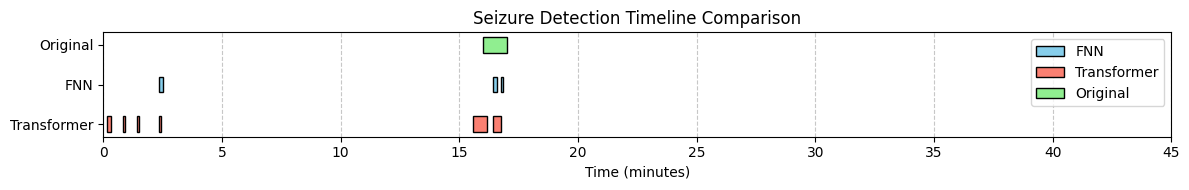

In [ ]:
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy
from datetime import timedelta
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, Add, GlobalAveragePooling1D, Attention, Reshape, Permute
import tensorflow as tf
from google.colab import drive

drive.mount('/content/drive')

SAMPLING_RATE = 512
DOWNSAMPLED_RATE = 128
WINDOW_SIZE_SEC = 5
WINDOW_SIZE = WINDOW_SIZE_SEC * DOWNSAMPLED_RATE
CHANNELS = 34
FEATURES_PER_CHANNEL = 7
INPUT_DIM = FEATURES_PER_CHANNEL * CHANNELS

dataset_path = '/content/drive/My Drive/Colab Notebooks/IEEE EMBS Internship/EEG Dataset'

seizure_log = {
    "PN00-1.edf": ["19:39:33", ["19:58:36"]],
    "PN00-2.edf": ["02:18:17", ["02:38:37"]],
    "PN00-3.edf": ["18:15:44", ["18:28:29"]],
    "PN00-4.edf": ["20:51:43", ["21:08:29"]]
}

def time_to_seconds(t_str):
    h, m, s = map(int, t_str.split(':'))
    return h * 3600 + m * 60 + s

def seconds_to_clock(seconds):
    return str(timedelta(seconds=int(seconds)))

def extract_features(segment):
    features = []
    for ch_data in segment:
        ch_features = [
            np.mean(ch_data), np.std(ch_data), np.var(ch_data),
            np.max(ch_data), np.min(ch_data), np.ptp(ch_data),
            entropy(np.abs(np.fft.rfft(ch_data)) + 1e-8)
        ]
        features.extend(ch_features)
    return np.array(features)

def preprocess_and_segment(file_path):
    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
    raw.pick_channels(raw.ch_names[:CHANNELS])
    raw.resample(DOWNSAMPLED_RATE)
    data = raw.get_data()

    X = []
    total_samples = data.shape[1]
    n_windows = total_samples // WINDOW_SIZE

    for i in range(n_windows):
        start = i * WINDOW_SIZE
        end = start + WINDOW_SIZE
        segment = data[:, start:end]
        if segment.shape[1] < WINDOW_SIZE:
            continue
        features = extract_features(segment)
        X.append(features)
    return np.array(X), raw

from IPython.display import display

def get_detected_segments(preds_bin):
    segments = []
    for i, pred in enumerate(preds_bin):
        if pred == 1:
            start = i * WINDOW_SIZE_SEC
            end = start + WINDOW_SIZE_SEC
            segments.append((start, end))

    merged = []
    if segments:
        current_start, current_end = segments[0]
        for s, e in segments[1:]:
            if s - current_end in [0, 5]:
                current_end = e
            else:
                merged.append((current_start, current_end))
                current_start, current_end = s, e
        merged.append((current_start, current_end))
    return merged

fnn_preds = np.load('/content/drive/My Drive/Colab Notebooks/IEEE EMBS Internship/fnn_preds.npy')
transformer_preds = np.load('/content/drive/My Drive/Colab Notebooks/IEEE EMBS Internship/transformer_preds.npy')

fnn_segments = get_detected_segments((fnn_preds > 0.1).astype(int))
transformer_segments = get_detected_segments((transformer_preds > 0.5).astype(int))

# Timeline Overlay Plot
def plot_timeline_overlay(fnn_seg, trans_seg, title='Seizure Detection Timeline Comparison'):
    total_time = 2700
    height = 0.4

    manual_seg = [(16 , 17 + 2/60)]

    plt.figure(figsize=(12, 2))
    for (start, end) in fnn_seg:
        plt.barh(y=1, left=start/60, width=(end-start)/60, height=height, color='skyblue', edgecolor='black', label='FNN')
    for (start, end) in trans_seg:
        plt.barh(y=0, left=start/60, width=(end-start)/60, height=height, color='salmon', edgecolor='black', label='Transformer')
    for (start, end) in manual_seg:
        plt.barh(y=2, left=start, width=(end - start), height=height, color='lightgreen', edgecolor='black', label='Original')

    plt.yticks([0, 1, 2], ['Transformer', 'FNN', 'Original'])
    plt.xlabel('Time (minutes)')
    plt.xlim([0, 45])
    plt.title(title)
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.tight_layout()
    plt.show()


plot_timeline_overlay(fnn_segments, transformer_segments)
